In [146]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
from bs4 import BeautifulSoup
import copy 
from pandas.plotting import scatter_matrix 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GM 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn import metrics


In [272]:
### Load up appropriate DF Table  
restaurant_df_outlier_rm = pd.read_pickle("restaurant_clean_df_outlier_nan_pickle.pkl")
restaurant_df_outlier_rm.head()

,ID,Name,Latitude,Longitude,State,City,Category Name,Rating,Number of Rating,Price Tier,Average Menu Length,Average Item Price,Division
0,534f07e9498e5cc70137182b,The Causeway Restaurant and Pub,42.364659,-71.062912,MA,Boston,BBQ Joint,7.0,55.0,1.0,45.0,9.595556,1
1,593d9fb5c876c8327eef128d,Rusty Can,42.755437,-70.938839,MA,Byfield,BBQ Joint,8.0,14.0,1.0,18.0,8.618889,1
2,4ba2b7caf964a520211338e3,Joff's Backyard Grill,42.084574,-71.471883,MA,Bellingham,BBQ Joint,7.9,18.0,1.0,27.0,8.490000,1
3,5c5efed8419a9e002ce8ea9c,The Smoke Shop BBQ - Assembly Row,42.392249,-71.078180,MA,Somerville,Restaurant,7.7,4.0,1.0,59.0,12.457627,1
4,5ca25d74dd12f8002c74364b,Flip The Bird,42.559270,-70.881620,MA,Beverly,BBQ Joint,8.8,22.0,1.0,64.0,12.690000,1


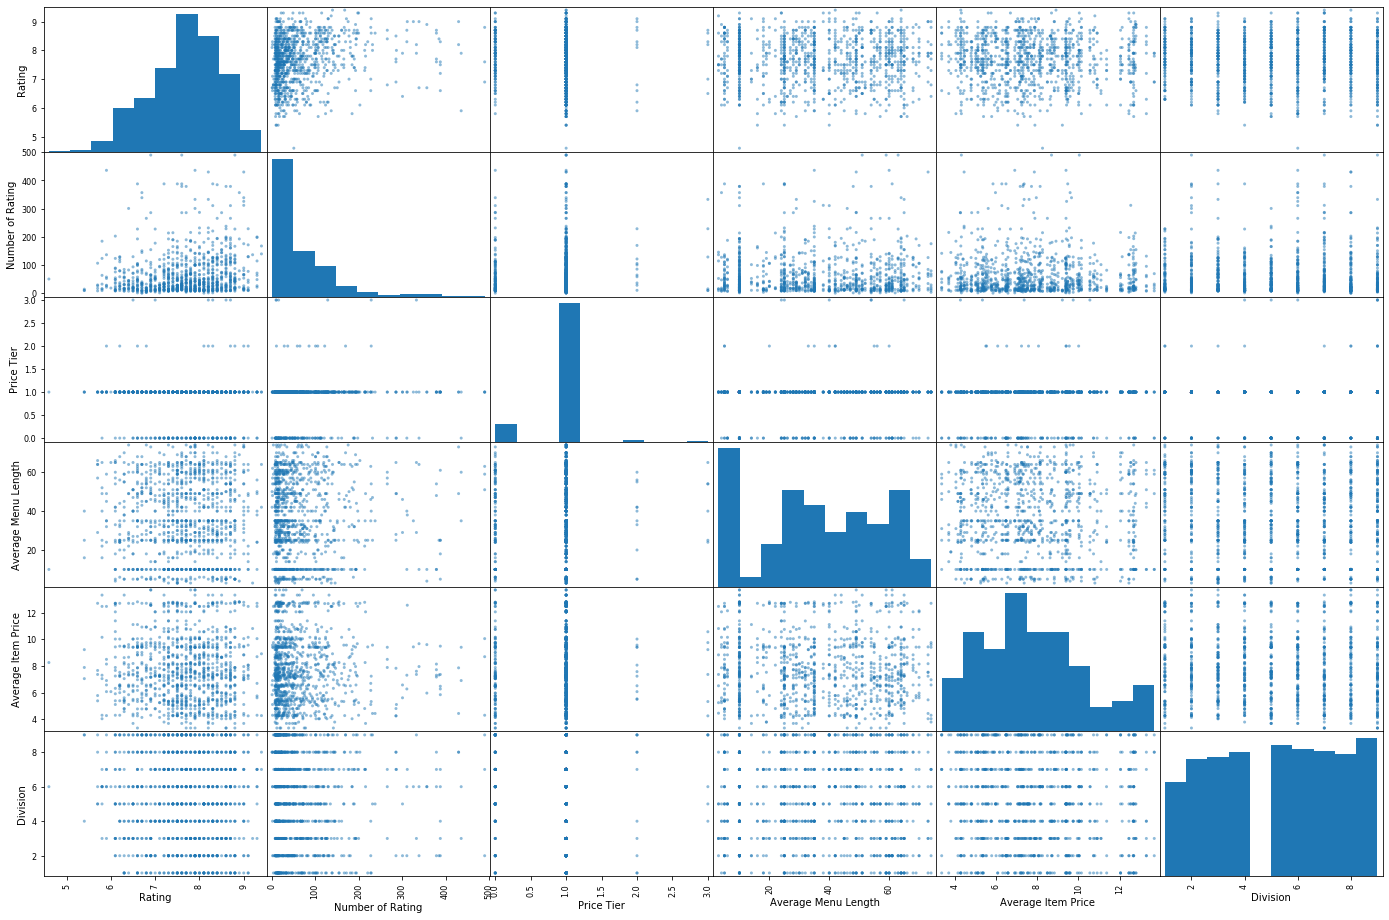

In [273]:
### Scatterplot to see correlation between attributes 
%matplotlib inline 

attributes = ["Rating", "Number of Rating", "Price Tier", "Average Menu Length", "Average Item Price", "Division"]
scatter_matrix(restaurant_df_outlier_rm[attributes], figsize=(24,16) ) ; 


In [274]:
### Setup our features and apply scaling 
features = restaurant_df_outlier_rm.drop(["ID", "Name", "State", "City", "Latitude", "Longitude", "Category Name"
                                         , "Division", "Price Tier", "Average Menu Length"], axis=1)
X = StandardScaler().fit(features).transform(features)

In [270]:
features.head()

,Rating,Number of Rating,Average Item Price
0,7.0,55.0,7.571429
1,8.0,14.0,7.525000
2,7.9,18.0,7.600000
3,6.7,124.0,12.457627
4,8.8,13.0,14.555690


In [310]:
### Code for visualization taken from sklearn website 
def cluster_visualize( X, n_clusters, feature_1, feature_2) : 
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 12)

    # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.5, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels="kmeans", random_state=10)
#     clusterer = GM(n_components=n_clusters, random_state = 10 )
#     clusterer = DBSCAN( eps = 1.0, min_samples = 5)
    
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples. 
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, feature_1], X[:, feature_2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, feature_1], centers[:, feature_2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[feature_1], c[feature_2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("K-Means analysis for Spectral clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 5 The average silhouette_score is : 0.299187762148586


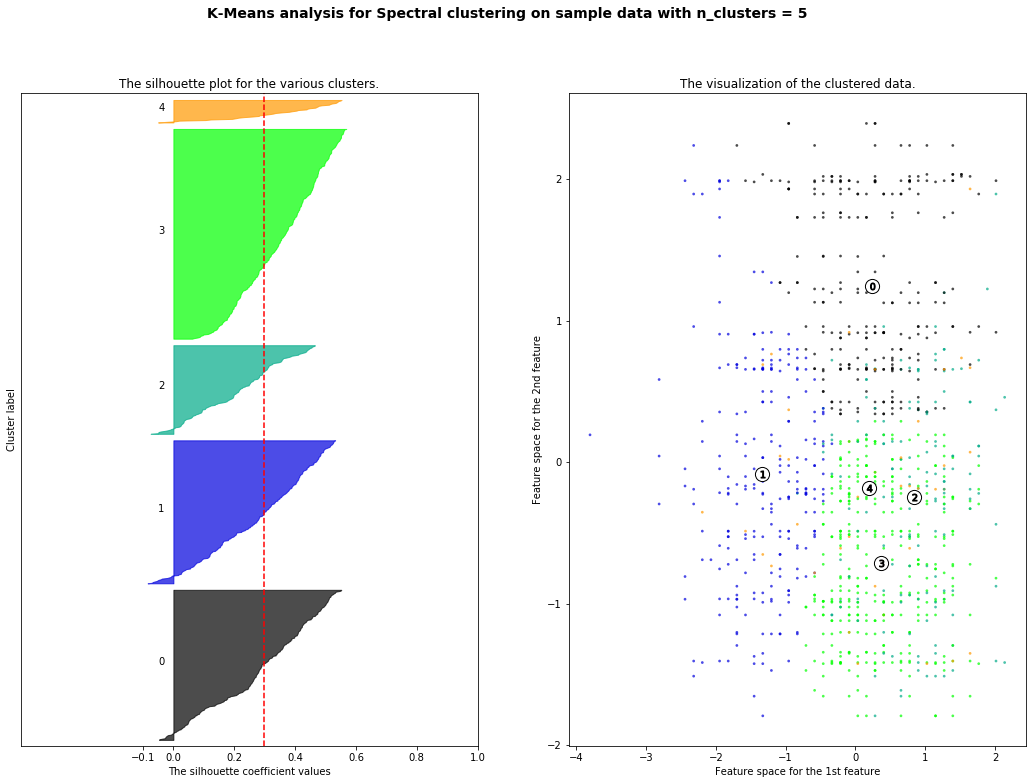

In [321]:
cluster_visualize(X, 5, 0, 2)

In [180]:
clusterer = DBSCAN( eps = 1.0, min_samples = 3)
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : -0.05854220874390492


Estimated number of clusters: 2
Estimated number of noise points: 21
Silhouette Coefficient: 0.494


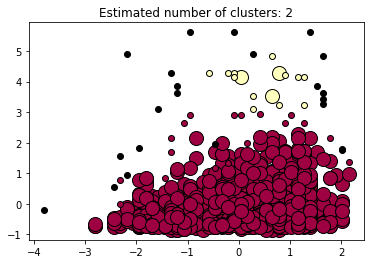

In [294]:
# Compute DBSCAN
db = DBSCAN(eps= 1.0, min_samples= 10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [295]:
restaurant_df_outlier_rm.index

RangeIndex(start=0, stop=1044, step=1)

In [296]:
row_indice = np.where(labels == 1)[0]
restaurant_df_outlier_rm.iloc[row_indice]

,ID,Name,Latitude,Longitude,State,City,Category Name,Rating,Number of Rating,Price Tier,Average Menu Length,Average Item Price,Division
119,4cd573d7122ba143c4192ca1,Dinosaur Bar-B-Que,42.734600,-73.689244,NY,Troy,BBQ Joint,8.4,385.0,1.0,25.0,7.318182,2
127,5b8ad0a631fd14002c758e7c,Unihog,42.898373,-73.352850,NY,Hoosick Falls,BBQ Joint,7.6,388.0,1.0,25.0,6.476000,2
158,51b2306b498e43d578d7bd29,Bullbq's Burger Cafe,40.269864,-76.888302,PA,Harrisburg,BBQ Joint,8.3,311.0,1.0,10.0,6.272800,2
169,503923eee4b06348eb4d6260,Little Everett's BBQ,39.808870,-77.001290,PA,Hanover,BBQ Joint,7.7,379.0,1.0,10.0,7.168000,2
259,520e9ff911d2b12d923e69e1,Tamarack chicken and fish,40.076410,-82.966952,OH,Columbus,BBQ Joint,7.5,388.0,1.0,18.0,6.272800,3
271,4b64f537f964a52045dc2ae3,Weber Grill Restaurant,39.767612,-86.159902,IN,Indianapolis,American Restaurant,7.9,333.0,1.0,29.0,7.600000,3
442,5291360e11d20de90e42c30e,The Pit,36.003458,-78.899893,NC,Durham,BBQ Joint,7.9,301.0,1.0,46.0,5.610580,5
596,4c2b7217b34ad13ab4c3e9ce,Five Brothers BBQ,32.343436,-86.222641,AL,Montgomery,BBQ Joint,7.6,379.0,1.0,54.0,8.137143,6
612,515484d6e4b0bdae55d49c6d,Edley's East,36.175910,-86.756398,TN,Nashville,BBQ Joint,8.7,311.0,0.0,40.0,7.303571,6
667,4b747dfef964a520dddf2de3,Attus Apparel,38.000664,-84.524555,KY,Lexington,Clothing Store,7.2,388.0,1.0,5.0,5.843750,6
